### Bước 1: Khai báo thư viện

In [295]:
#Khai báo thư viện
import pandas as pd # Đọc dữ liệu
import numpy as np # Xử lý dữ liệu
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu

#Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import Dense  # Đầu ra
from keras.layers import SimpleRNN

#Kiểm tra độ chính xác mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo phần trăm sai số tuyệt đối trung bình

### Bước 2: Đọc dữ liệu

In [296]:
# Chuẩn bị dữ liệu
data = pd.read_csv('BID Historical Data.csv')

### Bước 3: Mô tả dữ liệu

In [297]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-01,19516.3,19592.8,19631.1,19439.7,1.65M,-0.58%
1,2017-12-04,19516.3,19669.3,20052.0,19516.3,1.27M,0.00%
2,2017-12-05,19057.0,19669.3,19669.3,19057.0,3.06M,-2.35%
3,2017-12-06,19018.8,18904.0,19057.0,18750.9,2.33M,-0.20%
4,2017-12-07,19133.6,19133.6,19248.4,18789.2,808.64K,0.60%
...,...,...,...,...,...,...,...
1324,2023-03-27,46000.0,45550.0,46150.0,45000.0,672.20K,0.99%
1325,2023-03-28,46000.0,46500.0,46800.0,46000.0,504.00K,0.00%
1326,2023-03-29,46200.0,46000.0,46350.0,45550.0,303.10K,0.43%
1327,2023-03-30,46200.0,46250.0,46600.0,46200.0,699.70K,0.00%


In [298]:
# Kích thước dữ liệu
data.shape

(1329, 7)

In [299]:
# Xem dữ liệu 10 dòng đầu
data.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-01,19516.3,19592.8,19631.1,19439.7,1.65M,-0.58%
1,2017-12-04,19516.3,19669.3,20052.0,19516.3,1.27M,0.00%
2,2017-12-05,19057.0,19669.3,19669.3,19057.0,3.06M,-2.35%
3,2017-12-06,19018.8,18904.0,19057.0,18750.9,2.33M,-0.20%
4,2017-12-07,19133.6,19133.6,19248.4,18789.2,808.64K,0.60%
5,2017-12-08,19133.6,19171.8,19286.7,18865.7,1.07M,0.00%
6,2017-12-11,18368.2,18291.7,18980.5,18291.7,1.56M,-4.00%
7,2017-12-12,18444.8,18368.2,18674.4,17105.4,3.29M,0.42%
8,2017-12-13,18291.7,18444.8,18521.3,18100.4,2.54M,-0.83%
9,2017-12-14,18712.6,18215.2,18750.9,17794.2,1.85M,2.30%


In [300]:
# Xác định kiểu dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1329 non-null   object 
 1   Price     1329 non-null   float64
 2   Open      1329 non-null   float64
 3   High      1329 non-null   float64
 4   Low       1329 non-null   float64
 5   Vol.      1329 non-null   object 
 6   Change %  1329 non-null   object 
dtypes: float64(4), object(3)
memory usage: 72.8+ KB


In [301]:
# Mô tả bộ dữ liệu
data.describe()

,Price,Open,High,Low
count,1329.000000,1329.000000,1329.000000,1329.000000
mean,31848.289014,31833.519789,32364.304740,31359.551016
std,6471.838843,6478.017596,6569.183256,6392.221642
min,16531.400000,16378.300000,17602.900000,15957.400000
25%,26710.500000,26710.500000,27169.700000,26404.300000
50%,31685.200000,31752.700000,32180.800000,31379.100000
75%,35614.300000,35614.300000,36168.300000,35021.400000
max,49000.000000,49500.000000,49950.000000,48100.000000


### Bước 4: Tiền xử lý dữ liệu

In [302]:
#Định dạng lại cột Date từ obj -> datetime
data['Date'] = pd.to_datetime(data['Date'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
#Lấy cột Price để xử lý và dự đoán
data = data.loc[:, ['Price']]

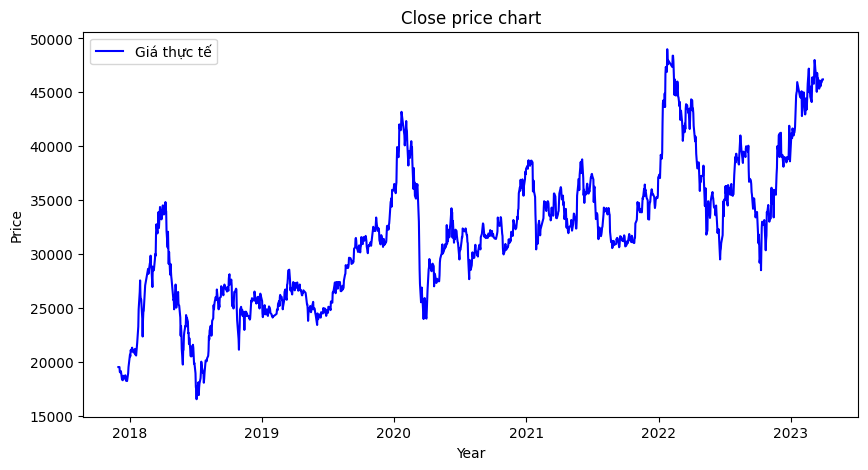

In [303]:
#Lập biểu đồ giá đóng
plt.figure(figsize=(10,5))
plt.plot(data['Price'], label='Giá thực tế', color='blue')
plt.title('Close price chart')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [304]:
data

,Price
Date,
2017-12-01,19516.3
2017-12-04,19516.3
2017-12-05,19057.0
2017-12-06,19018.8
2017-12-07,19133.6
...,...
2023-03-27,46000.0
2023-03-28,46000.0
2023-03-29,46200.0


In [307]:
# Chia tập dữ liệu thành 3 phần train (70%), valid (20%) và test (10%)
# Split data into train, validation, and test sets
train_size = int(len(data) * 0.7)
valid_size = int(len(data) * 0.2)
test_size = len(data) - train_size - valid_size
train = data[:train_size]
valid = data[train_size:train_size+valid_size]
test = data[train_size+valid_size:]

In [308]:
#Xem các tập đã chia
print(train)
print('\n', test)
print('\n', valid)

              Price
Date               
2017-12-01  19516.3
2017-12-04  19516.3
2017-12-05  19057.0
2017-12-06  19018.8
2017-12-07  19133.6
...             ...
2021-08-18  33754.5
2021-08-19  33635.8
2021-08-20  32052.9
2021-08-23  31103.2
2021-08-24  31182.3

[930 rows x 1 columns]

               Price
Date               
2022-09-19  34200.0
2022-09-20  35150.0
2022-09-21  34750.0
2022-09-22  35150.0
2022-09-23  34750.0
...             ...
2023-03-27  46000.0
2023-03-28  46000.0
2023-03-29  46200.0
2023-03-30  46200.0
2023-03-31  46200.0

[134 rows x 1 columns]

               Price
Date               
2021-08-25  31221.9
2021-08-26  30549.2
2021-08-27  30628.3
2021-08-30  31221.9
2021-08-31  30826.2
...             ...
2022-09-12  36900.0
2022-09-13  36800.0
2022-09-14  36500.0
2022-09-15  35750.0
2022-09-16  35500.0

[265 rows x 1 columns]


In [309]:
# Chuẩn hóa dữ liệu train, validation và test về khoảng giá trị [0, 1]
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
valid_scaled = scaler.transform(valid)
test_scaled = scaler.transform(test)

In [310]:
# Create sequences for RNN
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_valid, y_valid = create_sequences(valid_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

### Bước 5: Xây dựng và huấn luyện mô hình

In [311]:
# Build RNN model
# Gồm 2 thông số: số lượng mẫu, số lượng đặc trưng
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
# Compile model
model.compile(optimizer='adam', loss='mse')

In [312]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/50
28/28 [==============================] - 2s 20ms/step - loss: 0.0688 - val_loss: 0.0146
Epoch 2/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.0080
Epoch 3/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0097
Epoch 4/50
28/28 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 5/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 6/50
28/28 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 7/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 8/50
28/28 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 9/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 10/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 11/

### Bước 6: Sử dụng mô hình để dự đoán

In [313]:
# Evaluate the model
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform(y_train)
valid_pred = scaler.inverse_transform(valid_pred)
y_valid = scaler.inverse_transform(y_valid)
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test)

3/3 [==============================] - 0s 6ms/step


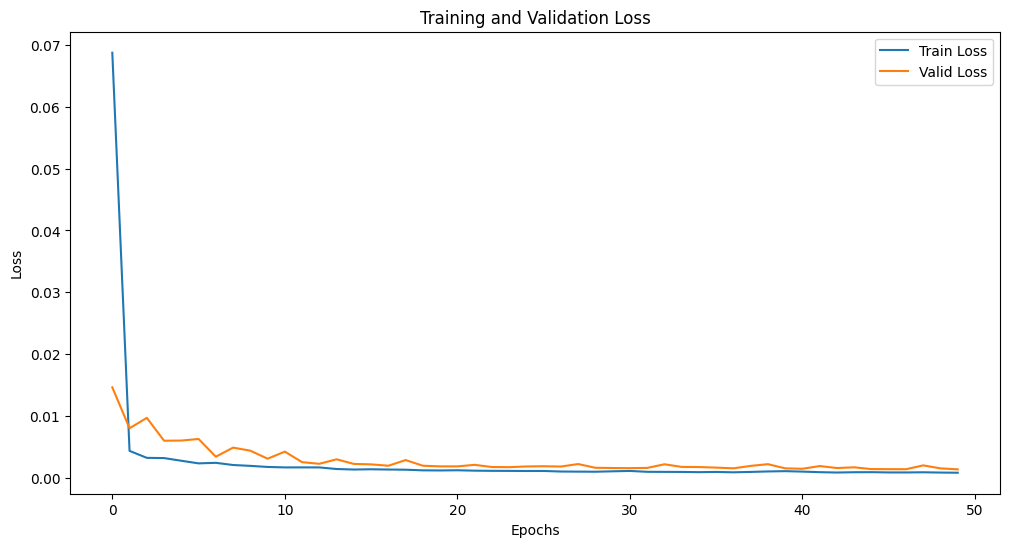

In [314]:
# Plot the results
# vẽ đồ thị biểu diễn sự thay đổi của giá trị hàm mất mát (loss) trên tập train và tập validation 
# qua các epoch của quá trình huấn luyện mô hình.
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25392\969682374.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1.loc[:,'Dự đoán'] = train_pred #Thêm dữ liệu
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25392\969682374.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data1.loc[:,'Dự đoán'] = valid_pred #Thêm dữ liệu
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25392\969682374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

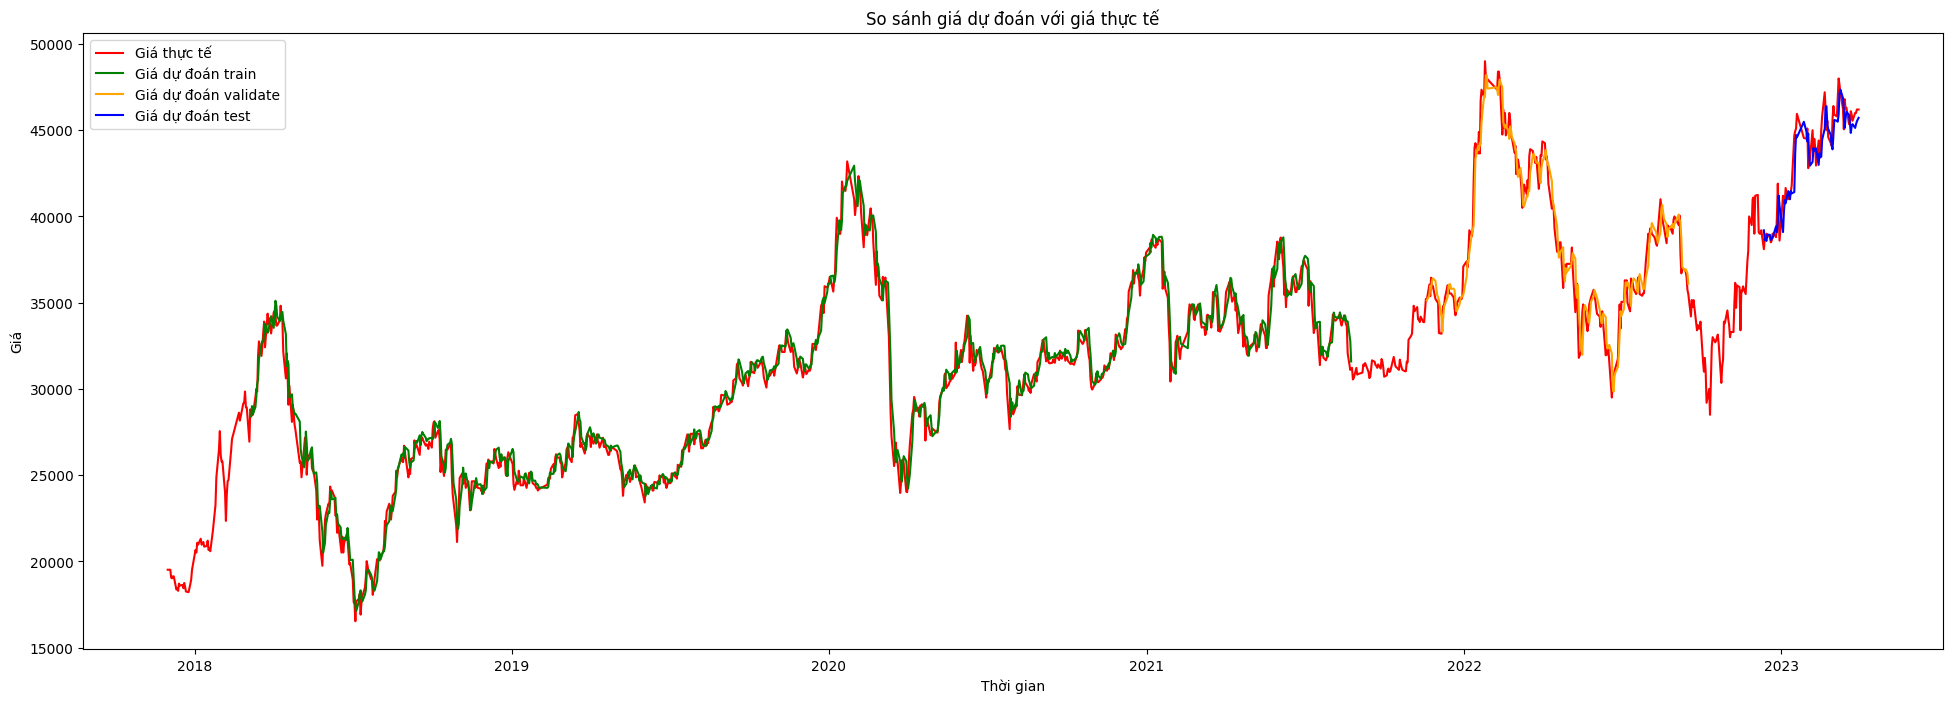

In [315]:
#Lập biểu đồ so sánh
train_data1 = data.iloc[60:930, :] #Train 70%
val_data1 = data.iloc[990:1195, :] #Validate 20%
test_data1 = data.iloc[1255:] #Test 10%

plt.figure(figsize=(24,8))
plt.plot(data, label='Giá thực tế', color='red')
train_data1.loc[:,'Dự đoán'] = train_pred #Thêm dữ liệu
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
val_data1.loc[:,'Dự đoán'] = valid_pred #Thêm dữ liệu
plt.plot(val_data1['Dự đoán'], label='Giá dự đoán validate', color='orange')
test_data1.loc[:,'Dự đoán'] = test_pred #Thêm dữ liệu
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự đoán với giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.show()

### Độ chính xác của mô hình

In [316]:
#R2
print('\n\nĐộ phù hợp tập test', r2_score(y_test, test_pred))
#mse
mse_test = mean_squared_error(y_test, test_pred)
print('Mức độ sai khác giữa giá trị dự đoán và giá trị thực tế', mse_test)
#mae
mae_test = mean_absolute_error(y_test, test_pred)
print('Sai số tuyệt đối trung bình tập test:', mae_test)
#rmse
rmse_test = np.sqrt(mse_test)
print('RMSE: ', rmse_test)
#mape
#CT: mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
mape_test = mean_absolute_percentage_error(y_test, test_pred)
print('Phẩn trăm Sai số tuyệt đối trung bình tập test:', mape_test)



Độ phù hợp tập test 0.863077529351566
Mức độ sai khác giữa giá trị dự đoán và giá trị thực tế 1086480.554718427
Sai số tuyệt đối trung bình tập test: 783.0979729729725
RMSE:  1042.343779526902
Phẩn trăm Sai số tuyệt đối trung bình tập test: 0.017798483871727482


In [317]:
#Bảng dữ liệu dữ đoán giá cụ thể ở tập test
test_data1

,Price,Dự đoán
Date,,
2022-12-12,38100.0,39193.722656
2022-12-13,38700.0,38625.421875
2022-12-14,38800.0,38665.109375
2022-12-15,39000.0,38582.562500
2022-12-16,38900.0,38952.621094
...,...,...
2023-03-27,46000.0,45132.789062
2023-03-28,46000.0,45340.433594
2023-03-29,46200.0,45513.066406


### Dự đoán giá chứng khoán cho 30 ngày tiếp theo

In [318]:
# Dự đoán giá chứng khoán cho 30 ngày tiếp theo
n_steps = 30
y_pred = []
# y_true = []
for i in range(0, len(X_test)-n_steps+1, n_steps):
    X = X_test[i:i+n_steps]
    y = y_test[i:i+n_steps]
    y_pred.extend(model.predict(X))
    # y_true.extend(y)

# Chuyển đổi giá chứng khoán dự đoán trở lại đơn vị ban đầu
y_pred = scaler.inverse_transform(y_pred)
# y_true = scaler.inverse_transform(y_true)

# In ra giá chứng khoán dự đoán
print("Giá chứng khoán dự đoán:", y_pred)
# print("Giá chứng khoán thực tế:", y_true)

1/1 [==============================] - 0s 27ms/step
Giá chứng khoán dự đoán: [[39193.72249594]
 [38625.42152758]
 [38665.10908947]
 [38582.56201191]
 [38952.62222605]
 [38929.94180307]
 [38642.01230783]
 [38719.40734425]
 [38749.57427735]
 [38936.76245718]
 [39422.74836464]
 [39089.72500153]
 [39663.69448647]
 [41209.12725668]
 [40606.99635248]
 [39094.49246712]
 [40235.29930849]
 [40944.3326828 ]
 [40763.48364305]
 [41470.55282154]
 [41298.97491322]
 [40998.28450174]
 [41467.72253613]
 [41336.11982679]
 [41414.60979114]
 [43652.28492184]
 [44721.19520378]
 [44584.15917282]
 [45488.66817131]
 [44906.99922943]
 [44350.89025974]
 [44808.68137569]
 [43623.14299383]
 [42942.44902415]
 [43165.12621784]
 [43969.52797384]
 [43812.9580472 ]
 [43880.65288029]
 [43943.87265234]
 [42988.43122978]
 [43659.31534443]
 [43431.5639782 ]
 [43467.16741123]
 [44439.08837318]
 [45087.52725983]
 [46327.54188185]
 [46393.24073601]
 [45271.87561932]
 [45078.37372589]
 [44712.77585955]
 [44115.60629787]
 [438